In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import math
import pickle

In [2]:
data = pd.read_csv('E:\mini\Bengaluru_House_data.csv')
#Show Overview
print(data.shape)
data.head()

df = pd.DataFrame(data)
to_drop = ['Devarachikkanahalli']
#making it a dataframe

(13320, 9)


In [3]:
df['area_type'].value_counts()

Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: area_type, dtype: int64

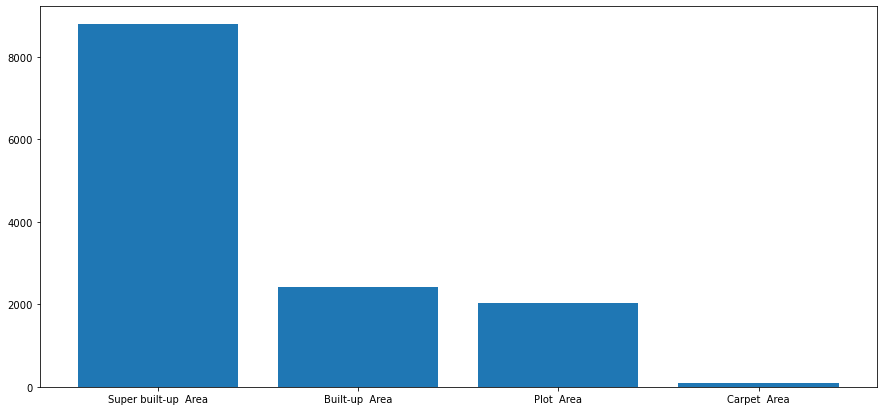

In [4]:
plt.figure(figsize=(15,7))
plt.bar(df['area_type'].value_counts().index,df['area_type'].value_counts().values)
plt.show()

In [5]:
data['price'].value_counts()

75.00    310
65.00    302
55.00    275
60.00    270
45.00    240
        ... 
81.55      1
69.49      1
42.18      1
70.25      1
74.82      1
Name: price, Length: 1994, dtype: int64

<Figure size 1080x504 with 0 Axes>

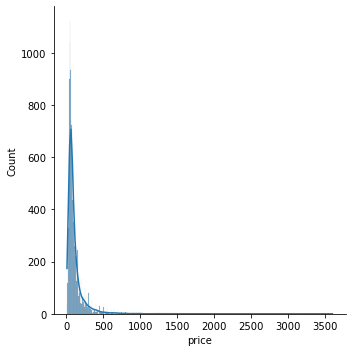

In [6]:
plt.figure(figsize=(15,7)) 
sns.displot(df['price'],kde=True)


In [7]:
#looking for nulls
df.isnull().sum()

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

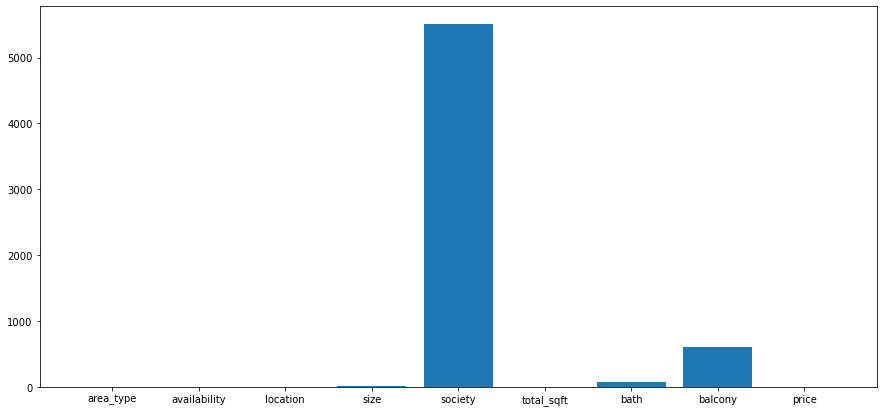

In [8]:
plt.figure(figsize=(15,7))
plt.bar(df.isnull().sum().index,df.isnull().sum().values)
plt.show()

In [9]:
#removing society due to large number of nulls.
df=df.drop(['society' ,'availability'], axis = 'columns')


In [10]:
#looking for nulls after society removal
df.isnull().sum()

area_type       0
location        1
size           16
total_sqft      0
bath           73
balcony       609
price           0
dtype: int64

In [11]:
df.describe()

,bath,balcony,price
count,13247.000000,12711.000000,13320.000000
mean,2.692610,1.584376,112.565627
std,1.341458,0.817263,148.971674
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,50.000000
50%,2.000000,2.000000,72.000000
75%,3.000000,2.000000,120.000000
max,40.000000,3.000000,3600.000000


In [12]:
df['location'].value_counts()

Whitefield           540
Sarjapur  Road       399
Electronic City      302
Kanakpura Road       273
Thanisandra          234
                    ... 
Jayanagar,             1
Dwaraka Nagar          1
Xavier Layout          1
Geetanjali Layout      1
Meenakshi Layout       1
Name: location, Length: 1305, dtype: int64

In [13]:
#for handling null values of bath and balconies that have numerical values
#we can use mean values instead of the nulls
#we take the locations where not null

df['balcony']=df['balcony'].fillna(df['balcony'].mean())
df['bath']=df['bath'].fillna(df['bath'].mean())

df = df[df['size'].notna()]
df = df[df['location'].notna()]

df.isnull().sum()
df= df.drop_duplicates()

In [14]:
#to convert to int
def int_float(x):
    try:
        return int(x)
    except:
        return float(x)
    return True

In [15]:
df['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [16]:
#converting size into uniform BHK e.g.1,2,3,4..
#df['BHK'] = df['size'].str.replace("%",'1',regex=True)
df['size'] = df['size'].apply(lambda x: int(x.split(' ')[0]))
#df['size'] = df['size'].apply(lambda x: f"{x} BHK")
df['size'] = df['size'].apply(int_float)


In [17]:
df.total_sqft.unique()
#df.isnull().sum()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [18]:
#total_sqft cleaning

In [19]:
def check_float(x):
    try:
        float(x)
    except:
        return False
    return True
df[~df['total_sqft'].apply(check_float)].head(10)

,area_type,location,size,total_sqft,bath,balcony,price
30,Super built-up Area,Yelahanka,4,2100 - 2850,4.00000,0.000000,186.000
56,Built-up Area,Devanahalli,4,3010 - 3410,2.69261,1.584376,192.000
81,Built-up Area,Hennur Road,4,2957 - 3450,2.69261,1.584376,224.500
122,Super built-up Area,Hebbal,4,3067 - 8156,4.00000,0.000000,477.000
137,Super built-up Area,8th Phase JP Nagar,2,1042 - 1105,2.00000,0.000000,54.005
165,Super built-up Area,Sarjapur,2,1145 - 1340,2.00000,0.000000,43.490
188,Super built-up Area,KR Puram,2,1015 - 1540,2.00000,0.000000,56.800
224,Super built-up Area,Devanahalli,3,1520 - 1740,2.69261,1.584376,74.820
410,Super built-up Area,Kengeri,1,34.46Sq. Meter,1.00000,0.000000,18.500
549,Super built-up Area,Hennur Road,2,1195 - 1440,2.00000,0.000000,63.770


In [20]:
#We have to convert these range values to a single area value
#we can make use of average of all these range values.
def sft_to_num(x):
    tokens = x.split('-')
    if len(tokens)==2:
        return (float(tokens[0]) + float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None
df['total_sqft'] = df['total_sqft'].apply(sft_to_num)
df.head()
df[~df['total_sqft'].apply(check_float)].head(10)

,area_type,location,size,total_sqft,bath,balcony,price


In [21]:
#check for nulls in sqft
df.isnull().sum()
df['total_sqft']=df['total_sqft'].fillna(df['total_sqft'].mean())


In [22]:
df[['size','price']].groupby(['size'],as_index=False).mean().sort_values(by='price',ascending=False)

,size,price
18,43,660.000000
14,16,550.000000
9,10,530.000000
16,19,490.000000
11,12,300.000000
4,5,282.261429
12,13,275.000000
3,4,272.086664
6,7,244.313131
8,9,241.944444


In [23]:
#as we see from above that some of the houses with  7 bhks have lesser
#price than some with 4 bhks, which doesn't make sense, thus we need to
#have a measure which gives the right price for a particular sized house
#thus comes in picture the price_per_sqrft
df['price_per_sqrft'] = df['price']*100000/df['total_sqft']

In [24]:
df['location'].describe()


count          12612
unique          1304
top       Whitefield
freq             513
Name: location, dtype: object

In [25]:
#OUTLIER REMOVAL
#since we have so many locations it is tough as we will have alot of features
#reducing the locations with less than 10 instances to other

In [26]:
loc = df['location'].value_counts()

In [27]:
loc_less10 = loc[loc <= 10]

In [28]:
df['location'] = df['location'].apply(lambda x: 'Rest of Bangalore' if x in loc_less10 else x)

In [29]:
df['location'].value_counts()


Rest of Bangalore    2949
Whitefield            513
Sarjapur  Road        366
Electronic City       280
Kanakpura Road        230
                     ... 
HAL 2nd Stage          11
Doddakallasandra       11
Nehru Nagar            11
Banjara Layout         11
LB Shastri Nagar       11
Name: location, Length: 233, dtype: int64

In [30]:
def lessthan300(x):
    if x <=300:
        return 0
    try:
        return x
    except:
        return None
df['total_sqft'] = df['total_sqft'].apply(lessthan300)
df[df.total_sqft <300].head()

,area_type,location,size,total_sqft,bath,balcony,price,price_per_sqrft
119,Plot Area,Hennur Road,2,0.0,3.0,3.0,23.00,8333.333333
349,Plot Area,Rest of Bangalore,3,0.0,3.0,2.0,74.00,672727.272727
1020,Carpet Area,Rest of Bangalore,1,0.0,1.0,0.0,30.00,200000.000000
1122,Built-up Area,Rest of Bangalore,5,0.0,2.0,2.0,150.00,625000.000000
2486,Super built-up Area,Rest of Bangalore,1,0.0,1.0,0.0,22.89,7733.108108


In [31]:
#removing these values
df = df.drop(df[df['total_sqft'] <300].index)
df.head()
#df[df.location=='Hey'].head()

,area_type,location,size,total_sqft,bath,balcony,price,price_per_sqrft
0,Super built-up Area,Electronic City Phase II,2,1056.0,2.0,1.0,39.07,3699.810606
1,Plot Area,Chikka Tirupathi,4,2600.0,5.0,3.0,120.00,4615.384615
2,Built-up Area,Uttarahalli,3,1440.0,2.0,3.0,62.00,4305.555556
3,Super built-up Area,Lingadheeranahalli,3,1521.0,3.0,1.0,95.00,6245.890861
4,Super built-up Area,Kothanur,2,1200.0,2.0,1.0,51.00,4250.000000


In [32]:
#as we see from above that some of the houses with  7 bhks have lesser
#price than some with 4 bhks, which doesn't make sense, thus we need to
#have a measure which gives the right price for a particular sized house
#thus comes in picture the price_per_sqrft
df['price_per_sqrft'] = df['price']*100000/df['total_sqft']

In [33]:
#converting bath and balcony to int
df['bath'] = df['bath'].apply(int_float)
df['balcony'] = df['balcony'].apply(int_float)

df.head()



,area_type,location,size,total_sqft,bath,balcony,price,price_per_sqrft
0,Super built-up Area,Electronic City Phase II,2,1056.0,2,1,39.07,3699.810606
1,Plot Area,Chikka Tirupathi,4,2600.0,5,3,120.00,4615.384615
2,Built-up Area,Uttarahalli,3,1440.0,2,3,62.00,4305.555556
3,Super built-up Area,Lingadheeranahalli,3,1521.0,3,1,95.00,6245.890861
4,Super built-up Area,Kothanur,2,1200.0,2,1,51.00,4250.000000


In [34]:
#number of bathrooms should be equal the number of rooms 
#or two more than the rooms
df=df[df['bath'].astype(int) <= df['size'].astype(int)+2]
df=df[df['balcony']<= df['size']]
df2=df.groupby('location')
df2.head()

,area_type,location,size,total_sqft,bath,balcony,price,price_per_sqrft
0,Super built-up Area,Electronic City Phase II,2,1056.0,2,1,39.07,3699.810606
1,Plot Area,Chikka Tirupathi,4,2600.0,5,3,120.00,4615.384615
2,Built-up Area,Uttarahalli,3,1440.0,2,3,62.00,4305.555556
3,Super built-up Area,Lingadheeranahalli,3,1521.0,3,1,95.00,6245.890861
4,Super built-up Area,Kothanur,2,1200.0,2,1,51.00,4250.000000
...,...,...,...,...,...,...,...,...
8077,Built-up Area,Banjara Layout,2,1050.0,2,1,64.80,6171.428571
8107,Plot Area,Mahalakshmi Layout,4,1050.0,1,0,35.00,3333.333333
8199,Super built-up Area,Kadubeesanahalli,3,1424.0,2,2,75.00,5266.853933
8599,Super built-up Area,LB Shastri Nagar,2,1250.0,2,2,48.50,3880.000000


In [35]:
#to check for location other's size and bath error encountered
#df[df.location=="other"].head()
df = df.drop(df[df['size'] >10 ].index)

df[['size','price']].groupby(['size'],as_index=False).mean().sort_values(by='price',ascending=False)

,size,price
9,10,293.846154
4,5,278.567529
3,4,270.566053
6,7,245.632653
8,9,230.196078
5,6,220.807339
7,8,208.627907
2,3,112.473324
1,2,59.852990
0,1,45.001775


In [36]:
df.price_per_sqrft.describe()

count     12212.000000
mean       6804.217571
std        4581.191380
min         267.829813
25%        4312.697230
50%        5500.000000
75%        7473.192545
max      176470.588235
Name: price_per_sqrft, dtype: float64

In [37]:
def remove_price_loc_outliers(df):
    df_out = pd.DataFrame()
    for key , subdf in df.groupby('location'):
        m = subdf['price_per_sqrft'].mean()
        st = subdf['price_per_sqrft'].std()
        reduced_df = subdf[(subdf.price_per_sqrft>(m-st)) & (subdf.price_per_sqrft<(m+st))]
        df_out = pd.concat([df_out , reduced_df] , ignore_index = True)
    return df_out

df = remove_price_loc_outliers(df)

In [38]:
df[['size','price']].groupby(['size'],as_index=False).mean().sort_values(by='price',ascending=False)


,size,price
9,10,285.000000
6,7,247.630435
3,4,218.064944
8,9,208.041667
4,5,188.304455
5,6,181.905172
7,8,170.785714
2,3,105.205425
1,2,58.982663
0,1,38.556132


In [39]:
df['price_per_sqrft'].describe()

count    10147.000000
mean      5961.821661
std       2614.514910
min       1875.000000
25%       4319.092852
50%       5303.030303
75%       6729.124638
max      27083.333333
Name: price_per_sqrft, dtype: float64

In [40]:
#MODEL PREPERATION
df = df.drop(['price_per_sqrft'], axis=1)
df.head()


,area_type,location,size,total_sqft,bath,balcony,price
0,Super built-up Area,Devarachikkanahalli,3,1250.0,2,3,44.0
1,Super built-up Area,Devarachikkanahalli,2,1250.0,2,2,40.0
2,Plot Area,Devarachikkanahalli,2,1200.0,2,2,83.0
3,Super built-up Area,Devarachikkanahalli,2,1170.0,2,2,40.0
4,Super built-up Area,Devarachikkanahalli,3,1425.0,2,2,65.0


In [41]:
dummies = pd.get_dummies(df.location)
df2= pd.concat([df,dummies.drop('Rest of Bangalore',axis='columns')], axis='columns')
df2.head()

,area_type,location,size,total_sqft,bath,balcony,price,Devarachikkanahalli,1st Block Jayanagar,1st Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,Super built-up Area,Devarachikkanahalli,3,1250.0,2,3,44.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Super built-up Area,Devarachikkanahalli,2,1250.0,2,2,40.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Plot Area,Devarachikkanahalli,2,1200.0,2,2,83.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Super built-up Area,Devarachikkanahalli,2,1170.0,2,2,40.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Super built-up Area,Devarachikkanahalli,3,1425.0,2,2,65.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
dummies = pd.get_dummies(df2.area_type).drop('Super built-up  Area', axis='columns')
df3 = pd.concat([df2,dummies], axis='columns')

In [43]:
df3 = df3.drop(['location','area_type'],axis=1)
df3.head()


,size,total_sqft,bath,balcony,price,Devarachikkanahalli,1st Block Jayanagar,1st Phase JP Nagar,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,Built-up Area,Carpet Area,Plot Area
0,3,1250.0,2,3,44.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1250.0,2,2,40.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1200.0,2,2,83.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2,1170.0,2,2,40.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,1425.0,2,2,65.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
X = df3.drop('price',axis="columns")
Y = df3.price

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=10)

In [46]:
from sklearn.linear_model import LinearRegression
#build model usingg Linear Regression inbuilt function
#name it as lr_model
lr_model = LinearRegression()
# training our model
lr_model.fit(X_train,Y_train)
#testing our fitted model,score gives accuracy of fitted model wrt
#to testing data
lr_model.score(X_test,Y_test)*100


79.51729531175296

In [47]:
def predict_price(location,size,total_sqft,bath,balcony,area_type):
    loc_index, area_index = -1,-1
    
    
    if location!='Rest of Bangalore':
        loc_index = int(np.where(X.columns==location)[0][0])
    
    if area_type!='Super built-up  Area':
        area_index = np.where(X.columns==area_type)[0][0]
        
    x=np.zeros(len(X.columns))
    x[0] = size
    x[1] = total_sqft
    x[2] = bath
    x[3] = balcony
    
    
    if loc_index >=0:
        x[loc_index] = 1
        
    if area_index >= 0:
        x[area_index] = 1
    return lr_model.predict([x])[0]

predict_price('1st Block Jayanagar',2,1000,2,1,'Built-up  Area')

152.15790790147958

In [48]:
df3.to_csv('E:\mini\Bengaluru.csv')

In [49]:
filename='Bengaluru_house.pkl'
pickle.dump(lr_model ,open(filename , 'wb'))

In [50]:
###Trying the model from the pickle file
filename='Bengaluru_house.pkl'

model_load = pickle.load(open(filename, 'rb'))
res = model_load.score(X_test,Y_test)
print(res*100)

79.51729531175296
